# Hospital Anomalies: Isolation Forest Baseline Model

This notebook demonstrates the baseline Isolation Forest anomaly detection model with:
- **Deterministic NaN-free feature engineering**
- **Interactive anomaly date tables with Google search links**
- **Mathematical explanation of Isolation Forest algorithm**
- **Annotated visualizations with anomaly dates**

In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent.parent.parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from case_studies.hospital_anomalies.src.utils import load_config
from case_studies.hospital_anomalies.src.features import build_features
from case_studies.hospital_anomalies.src.models.isolation_forest import IsolationForestDetector
from case_studies.hospital_anomalies.src.evaluation import get_anomaly_dates, print_anomaly_dates_table
from case_studies.hospital_anomalies.src.visualize import plot_time_series_with_anomalies

%matplotlib inline

## Mathematical Explanation: Isolation Forest

### Overview
Isolation Forest is an unsupervised anomaly detection algorithm based on the principle that **anomalies are rare and different**, making them easier to isolate from normal data points.

### Algorithm

#### 1. **Isolation Trees**
The algorithm builds an ensemble of *isolation trees* (iTrees). Each tree is constructed by:

1. Randomly selecting a feature $q$ from the feature set
2. Randomly selecting a split value $p$ between the minimum and maximum values of $q$
3. Recursively partitioning the data until:
   - All points are isolated (external nodes), or
   - Tree reaches maximum depth $\lceil \log_2(n) \rceil$ where $n$ is sample size

#### 2. **Path Length**
For each data point $x$, the **path length** $h(x)$ is the number of edges traversed from the root to the leaf node.

**Key Insight**: Anomalies have shorter average path lengths because they are easier to isolate.

#### 3. **Anomaly Score**
The anomaly score for a point $x$ is calculated as:

$$s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$$

where:
- $E(h(x))$ = average path length of $x$ across all trees
- $c(n)$ = normalization constant (average path length of unsuccessful search in BST)
- $c(n) = 2H(n-1) - \frac{2(n-1)}{n}$ where $H(i)$ is the harmonic number $\approx \ln(i) + 0.5772$

#### 4. **Interpretation**
- $s(x) \approx 1$: Anomaly (very short path length)
- $s(x) < 0.5$: Normal point (average path length)
- $s(x) \approx 0$: Normal point (very long path length)

### Advantages
1. **Linear time complexity**: $O(n \log n)$ for training
2. **No distance/density computations**: Works well in high dimensions
3. **Unsupervised**: No labeled data required
4. **Handles irrelevant features**: Random feature selection reduces impact

### Parameters
- `n_estimators`: Number of isolation trees (default: 100)
- `max_samples`: Number of samples to draw for each tree (default: 256)
- `contamination`: Expected proportion of anomalies (default: 'auto')
- `random_state`: Seed for reproducibility

## 1. Load Data and Configuration
Use the YAML config for defaults, but feel free to override the notebook-level `START_DATE` and `END_DATE` variables programmatically right after this cell.

In [2]:
# Load configuration
config_path = Path.cwd().parent / 'config' / 'default.yaml'
config = load_config(config_path)
config_dict = config.to_dict()

# Notebook-level date range that can be overridden programmatically
START_DATE = config_dict.get('date_range', {}).get('start', '2023-01-01')
END_DATE = config_dict.get('date_range', {}).get('end', '2023-12-31')

# Example override:
# START_DATE = (pd.Timestamp.today() - pd.Timedelta(days=180)).date().isoformat()
# END_DATE = pd.Timestamp.today().date().isoformat()

print(f"Active date range: {START_DATE} → {END_DATE}")

# For demo purposes, create synthetic data
np.random.seed(42)
dates = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
df = pd.DataFrame({
    'date': dates,
    'admissions': np.random.poisson(100, len(dates)) + np.random.randn(len(dates)) * 5,
    'occupancy_rate': np.random.uniform(0.7, 0.95, len(dates))
})

# Add some anomalies
anomaly_indices = [50, 51, 52, 150, 151, 250, 300]
df.loc[anomaly_indices, 'admissions'] = df.loc[anomaly_indices, 'admissions'] * 1.5
df.loc[anomaly_indices, 'occupancy_rate'] = 0.99

print(f"Loaded {len(df)} days of data")
df.head()

Active date range: 2015-01-01 → 2026-12-31
Loaded 4383 days of data


,date,admissions,occupancy_rate
0,2015-01-01,90.597963,0.792780
1,2015-01-02,101.112917,0.724172
2,2015-01-03,85.881546,0.756615
3,2015-01-04,100.554219,0.924426
4,2015-01-05,108.310107,0.944923


## 2. Feature Engineering with NaN Handling

Using `build_features()` which guarantees a NaN-free feature matrix.

In [3]:
# Build features with automatic NaN handling
features_df = build_features(df, config_dict)

print(f"Engineered {len(features_df.columns)} features")
print(f"Total NaNs in feature matrix: {features_df.isna().sum().sum()}")
print(f"\nFeature columns: {list(features_df.columns[:15])}...")

Engineered 48 features
Total NaNs in feature matrix: 0

Feature columns: ['date', 'admissions', 'occupancy_rate', 'year', 'month', 'day', 'day_of_week', 'day_of_year', 'quarter', 'week_of_year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'admissions_rolling_mean_7']...


## 3. Train Isolation Forest

In [4]:
# Select features (exclude date and metadata columns)
feature_cols = [
    col for col in features_df.columns
    if col not in ['date', 'region', 'hospital_id', 'year', 'month', 'day', 
                   'quarter', 'week_of_year', 'day_of_week', 'day_of_year']
]

X = features_df[feature_cols]
print(f"Training on {len(feature_cols)} features")

# Initialize and train Isolation Forest
if_config = config_dict.get('isolation_forest', {})
detector = IsolationForestDetector(
    n_estimators=if_config.get('n_estimators', 100),
    contamination=if_config.get('contamination', 0.1),
    random_state=42
)

detector.fit(X)
print("✓ Isolation Forest trained")

Training on 40 features
✓ Isolation Forest trained


## 4. Detect Anomalies

In [5]:
# Get anomaly predictions
predictions = detector.get_anomalies(X)

print(f"Total anomalies detected: {predictions['is_anomaly'].sum()}")
print(f"Anomaly rate: {predictions['is_anomaly'].mean():.2%}")

# Combine with original data
results_df = features_df.copy()
results_df['is_anomaly'] = predictions['is_anomaly']
results_df['anomaly_score'] = predictions['anomaly_score']

Total anomalies detected: 220
Anomaly rate: 5.02%


## 5. Anomaly Dates with Google Search Links

**Interactive table with clickable links to investigate events on anomaly dates**

In [6]:
# Extract anomaly dates with Google search links
anomaly_dates = get_anomaly_dates(
    results_df,
    date_col='date',
    anomaly_col='is_anomaly',
    score_col='anomaly_score',
    value_cols=['admissions', 'occupancy_rate'],
    include_search_links=True,
    include_news_placeholder=True
)

# Display interactive table (clickable links in Jupyter)
print_anomaly_dates_table(anomaly_dates, max_rows=100)

date,anomaly_score,admissions,occupancy_rate,google_search_link,news_headline
2015-01-01 (Thursday),-0.6739,90.5980,0.7928,Open in Google,"[Check news for January 01, 2015]"
2015-01-03 (Saturday),-0.6490,85.8815,0.7566,Open in Google,"[Check news for January 03, 2015]"
2015-02-23 (Monday),-0.6452,76.6255,0.8437,Open in Google,"[Check news for February 23, 2015]"
2015-01-02 (Friday),-0.6432,101.1129,0.7242,Open in Google,"[Check news for January 02, 2015]"
2015-02-22 (Sunday),-0.6421,143.3957,0.9900,Open in Google,"[Check news for February 22, 2015]"
2015-06-02 (Tuesday),-0.6414,94.2981,0.7595,Open in Google,"[Check news for June 02, 2015]"
2015-06-01 (Monday),-0.6396,189.2762,0.9900,Open in Google,"[Check news for June 01, 2015]"
2015-02-27 (Friday),-0.6321,131.0938,0.8402,Open in Google,"[Check news for February 27, 2015]"
2015-02-24 (Tuesday),-0.6196,115.2129,0.7209,Open in Google,"[Check news for February 24, 2015]"
2015-02-21 (Saturday),-0.6195,159.9076,0.9900,Open in Google,"[Check news for February 21, 2015]"


,date,anomaly_score,admissions,occupancy_rate,google_search_link,news_headline
0,2015-01-01,-0.673865,90.597963,0.792780,https://www.google.com/search?q=Canada%20news%...,"[Check news for January 01, 2015]"
1,2015-01-03,-0.649050,85.881546,0.756615,https://www.google.com/search?q=Canada%20news%...,"[Check news for January 03, 2015]"
2,2015-02-23,-0.645248,76.625540,0.843661,https://www.google.com/search?q=Canada%20news%...,"[Check news for February 23, 2015]"
3,2015-01-02,-0.643186,101.112917,0.724172,https://www.google.com/search?q=Canada%20news%...,"[Check news for January 02, 2015]"
4,2015-02-22,-0.642146,143.395692,0.990000,https://www.google.com/search?q=Canada%20news%...,"[Check news for February 22, 2015]"
...,...,...,...,...,...,...
95,2016-10-25,-0.521688,100.358124,0.764979,https://www.google.com/search?q=Canada%20news%...,"[Check news for October 25, 2016]"
96,2018-10-07,-0.521057,85.115522,0.867473,https://www.google.com/search?q=Canada%20news%...,"[Check news for October 07, 2018]"
97,2021-10-12,-0.520492,83.184595,0.724629,https://www.google.com/search?q=Canada%20news%...,"[Check news for October 12, 2021]"
98,2022-11-15,-0.520190,83.566446,0.822550,https://www.google.com/search?q=Canada%20news%...,"[Check news for November 15, 2022]"


## 6. Visualize Results with Date Labels

**Time series plot with anomalies highlighted and labeled with dates**

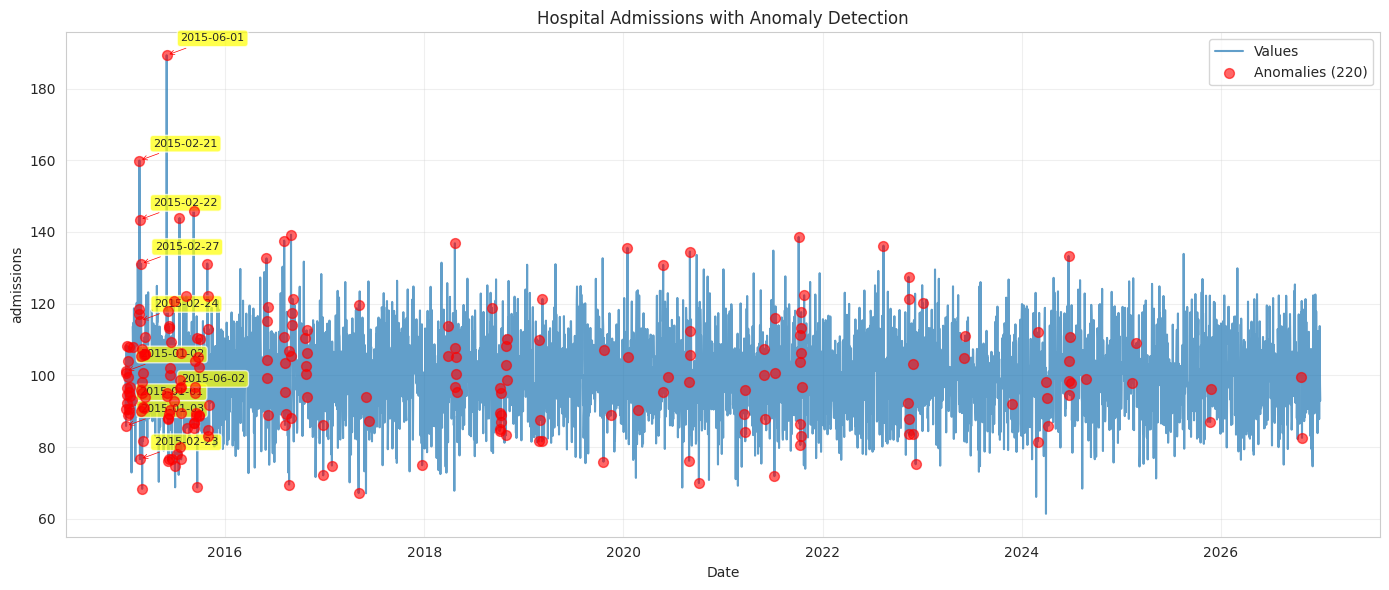

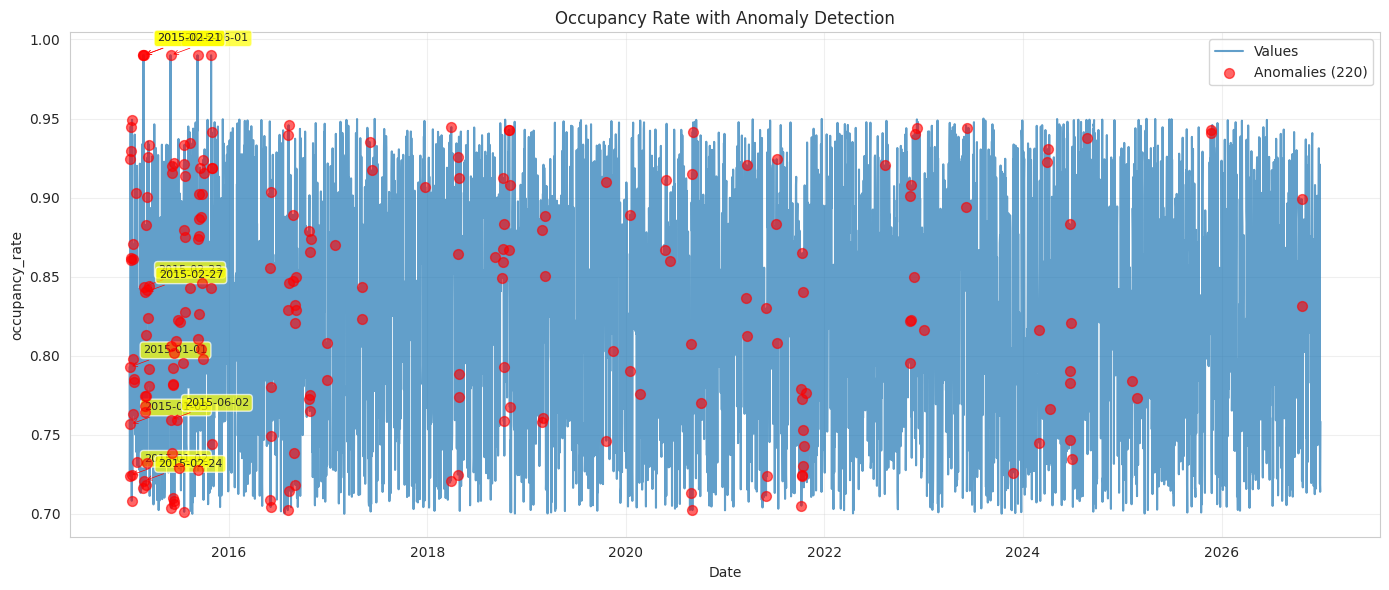

In [7]:
# Plot time series with anomaly labels
fig = plot_time_series_with_anomalies(
    results_df,
    date_col='date',
    value_col='admissions',
    anomaly_col='is_anomaly',
    title='Hospital Admissions with Anomaly Detection',
    annotate_dates=True,
    max_annotations=10
)
plt.show()

# Plot occupancy rate
fig = plot_time_series_with_anomalies(
    results_df,
    date_col='date',
    value_col='occupancy_rate',
    anomaly_col='is_anomaly',
    title='Occupancy Rate with Anomaly Detection',
    annotate_dates=True,
    max_annotations=10
)
plt.show()

## 7. Summary Statistics

In [8]:
# Summary of anomalies
print("=== Anomaly Detection Summary ===")
print(f"Total data points: {len(results_df)}")
print(f"Anomalies detected: {results_df['is_anomaly'].sum()}")
print(f"Anomaly rate: {results_df['is_anomaly'].mean():.2%}")
print(f"\nScore statistics:")
print(results_df['anomaly_score'].describe())

=== Anomaly Detection Summary ===
Total data points: 4383
Anomalies detected: 220
Anomaly rate: 5.02%

Score statistics:
count    4383.000000
mean       -0.445680
std         0.030200
min        -0.673865
25%        -0.459274
50%        -0.440738
75%        -0.425060
max        -0.388103
Name: anomaly_score, dtype: float64
